# **Exercise 7.04**
# **Building a Convolutional Neural Network with Additional Convolutional Layers**

You'll do this by building a horses-or-humans classifier that will tell you if a given image contains a horse or a human, where the network is trained to recognize features that determine which is which.


**Import libraries.**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import RMSprop
from keras_preprocessing import image as kimage
tf.config.run_functions_eagerly(True)

In [ ]:
(our_train_dataset, our_test_dataset), \
dataset_info = tfds.load('horses_or_humans', \
                         split = ['train', 'test'],\
                         data_dir = 'content/',\
                         shuffle_files = True,\
                         with_info = True)
assert isinstance(our_train_dataset, tf.data.Dataset)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
image_shape = dataset_info.features["image"].shape
names_of_classes = dataset_info.features["label"].names

our_cnn_model = models.Sequential([
    layers.Conv2D(filters = 16, kernel_size = (3,3), \
                  input_shape = image_shape),\
    layers.Activation('relu'),\
    layers.MaxPool2D(pool_size = (2, 2)),\

    layers.Conv2D(filters = 32, kernel_size = (3,3)),\
    layers.Activation('relu'),\
    layers.MaxPool2D(pool_size = (2, 2)),\

    layers.Flatten(),\
    layers.Dense(units = 512),\
    layers.Activation('relu'),\
    layers.Dense(units = 1),\
    layers.Activation('sigmoid')
])


In [ ]:
our_cnn_model.compile(optimizer=RMSprop(learning_rate=0.001), \
                      loss='binary_crossentropy',\
                      metrics=['acc'], loss_weights=None,\
                      weighted_metrics=None, run_eagerly=None,\
                      steps_per_execution=None
)


**Data preprocessing**


In [ ]:

normalization_layer = layers.Rescaling(1./255)
our_train_dataset = our_train_dataset.map\
                    (lambda x: (normalization_layer(x['image']), \
                                                    x['label']), \
                     num_parallel_calls =  \
                     tf.data.experimental.AUTOTUNE)
our_train_dataset = our_train_dataset.cache()
our_train_dataset = our_train_dataset.shuffle\
                    (len(our_train_dataset))
our_train_dataset = our_train_dataset.batch(128)
our_train_dataset = \
our_train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

our_test_dataset = our_test_dataset.map\
                   (lambda x: (normalization_layer(x['image']), \
                                                   x['label']),\
                    num_parallel_calls =  tf.data.experimental.AUTOTUNE)
our_test_dataset = our_test_dataset.cache()
our_test_dataset = our_test_dataset.batch(32)
our_test_dataset = our_test_dataset.prefetch\
                   (tf.data.experimental.AUTOTUNE)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


**Fit our model.**

In [ ]:
tf.config.run_functions_eagerly(True)
history = our_cnn_model.fit\
          (our_train_dataset, \
          validation_data = our_test_dataset, \
          epochs=15, \
          validation_steps=8, \
          verbose=1)


Epoch 1/15
9/9 [==============================] - 129s 13s/step - loss: 28.2280 - acc: 0.5443 - val_loss: 5.4822 - val_acc: 0.5000
Epoch 2/15
9/9 [==============================] - 111s 12s/step - loss: 0.9930 - acc: 0.7352 - val_loss: 0.4075 - val_acc: 0.8672
Epoch 3/15
9/9 [==============================] - 106s 12s/step - loss: 0.1377 - acc: 0.9513 - val_loss: 1.1562 - val_acc: 0.7578
Epoch 4/15
9/9 [==============================] - 112s 13s/step - loss: 0.0624 - acc: 0.9883 - val_loss: 1.1676 - val_acc: 0.7812
Epoch 5/15
9/9 [==============================] - 111s 12s/step - loss: 0.0190 - acc: 0.9990 - val_loss: 1.5149 - val_acc: 0.7695
Epoch 6/15
9/9 [==============================] - 116s 13s/step - loss: 0.3292 - acc: 0.9133 - val_loss: 1.5085 - val_acc: 0.5742
Epoch 7/15
9/9 [==============================] - 113s 13s/step - loss: 0.8383 - acc: 0.8754 - val_loss: 0.4985 - val_acc: 0.8945
Epoch 8/15
9/9 [==============================] - 113s 13s/step - loss: 0.1069 - acc: 0.9

**Check our predictions.**

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


[[0.5535001]]
Image is a human


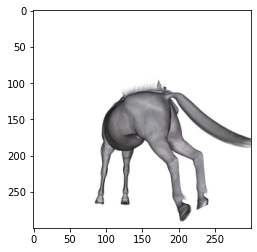

In [ ]:
import matplotlib.pyplot as plt

for images, lables in our_test_dataset.take(1):
    plt.imshow(np.asarray(images[0]))
    image_to_test = kimage.img_to_array(images[0])
    image_to_test = np.array([image_to_test])

    prediction = our_cnn_model.predict(image_to_test)
    print(prediction)
    if prediction > 0.5:
        print("Image is a human")
    else:
        print("Image is a horse")


**Visualizing representations.**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


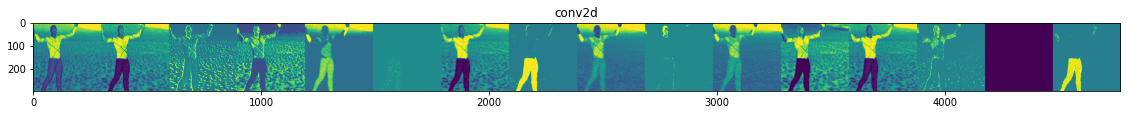

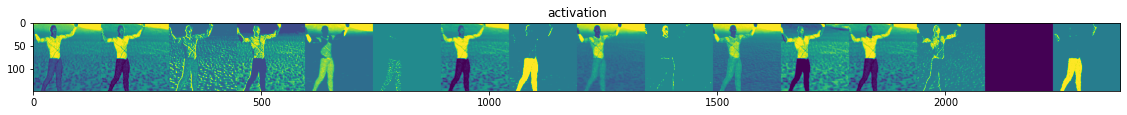

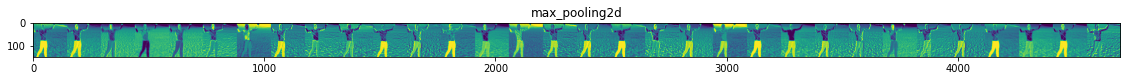

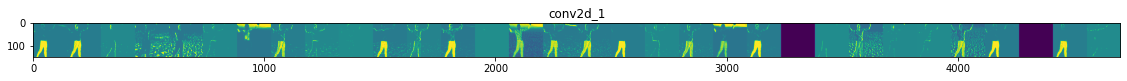

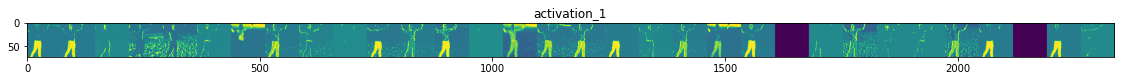

In [ ]:
layer_outputs = []
for layer in our_cnn_model.layers[1:]:
    layer_outputs.append(layer.output)
layer_names = []
for layer in our_cnn_model.layers:
    layer_names.append(layer.name)

features_model = models.Model(inputs = our_cnn_model.input, \
                              outputs = layer_outputs)
random_sample = our_train_dataset.take(1)

layer_predictions = features_model.predict(random_sample)

for layer_name, prediction in zip(layer_names, \
                                  layer_predictions):
    if len(prediction.shape) != 4:
        continue
    num_features = prediction.shape[-1]
    size = prediction.shape[1]
    grid = np.zeros((size, size * num_features))

    for i in range(num_features):
        img = prediction[0, :, :, i]
        img = ((((img - img.mean()) / img.std()) * 64) + 128)
        img = np.clip(img, 0, 255).astype('uint8')
        grid[:, i * size : (i + 1) * size] = img

    scale = 20. / num_features
    plt.figure(figsize=(scale * num_features, scale))
    plt.title(layer_name)
    plt.imshow(grid)
